In [1]:
import sys
print(sys.version)

3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [3]:
# Importing dependencies
import numpy as np
np.random.seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)
#import tensorflow 
import tensorflow as tf 
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

### Data Preprocessing

In [4]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [5]:
# Loading the dataset
url = '../DSE13-21.xlsx'
df = pd.read_excel(url,parse_dates = True,index_col=0)
#reverse dataset rows order
df=df.iloc[::-1]
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-01-30,4126.75,4126.75,4126.75,4126.75,-,-0.0067
2013-01-31,4136.30,4136.30,4136.30,4136.30,-,0.0023
2013-02-03,4163.82,4163.82,4163.82,4163.82,-,0.0067
2013-02-04,4164.62,4164.62,4164.62,4164.62,-,0.0002
2013-02-05,4191.50,4191.50,4191.50,4191.50,-,0.0065


In [6]:
# Correlation matrix
df.corr()['Price']

Price       1.000000
Open        0.999356
High        0.999535
Low         0.999598
Change %    0.026099
Name: Price, dtype: float64

In [20]:
#print(df.describe().High) 
#df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

In [57]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,dropout=0.0,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True,dropout=0.0))
    model.add(GRU(hl[-1],activation = 'relu',dropout=0.0))
    model.add(Dense(1))
    model.compile(optimizer = tf.optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [58]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    mae=mean_absolute_error(Y_test,Y_hat)
    mape=mean_absolute_percentage_error(Y_test,Y_hat)
    return mse,rmse, r2,mae,mape, Y_test, Y_hat
  

In [59]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [60]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [61]:
# Extracting the series
series = df[['Price','Open','High']] # Picking the features
print(series.shape)
print(series.tail())

(1931, 3)
              Price     Open     High
Date                                 
2021-03-16  5516.40  5532.97  5572.42
2021-03-18  5434.69  5516.40  5516.40
2021-03-21  5349.77  5434.69  5434.69
2021-03-22  5412.19  5349.77  5418.69
2021-03-23  5413.73  5412.19  5451.92


In [62]:
# Train Val Test Split
train_start = dt.date(2013,1,30)
train_end = dt.date(2018,3,7)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2018,3,8)
val_end = dt.date(2019,11,11)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2019,11,12)
test_end = dt.date(2021,3,23)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(1233, 3) (400, 3) (298, 3)


In [63]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1233, 3) (400, 3) (298, 3)


In [64]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

C:\Users\prabi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


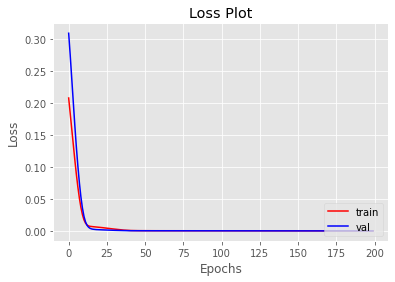

In [65]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.0012948017387191956
RMSE = 0.03598335363357889
R2-Score = 0.9660057872224398
MAE = 0.024507875971556983
MAPE = 0.07595734228811209


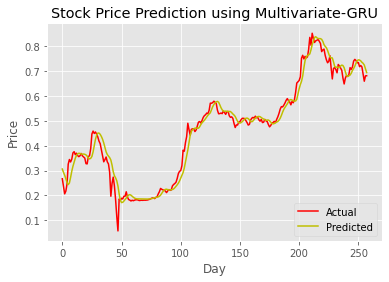

In [66]:
mse,rmse,r2_value,mae,mape,true,predicted = evaluate_model(model,test,40)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
print('MAE = {}'.format(mae))
print('MAPE = {}'.format(mape))
plot_data(true,predicted)